In [1]:
# %load_ext jupyter_ai_magics

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import umap
import torch, os, scipy
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
emb1 = model.encode("This wine has hints of fresh tennis ball.")
emb2 = model.encode("This wine has hints of a bowling alley.")

In [5]:
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.6378]])


In [21]:
# df0 = pd.read_csv('data/winemag-data_first150k.csv')
df = pd.read_csv('data/winemag-data-130k-v2.csv').drop(columns={'Unnamed: 0'})
# The 'first150k' file does not have the 'title'column
# df = pd.concat([df0,df1], ignore_index=True)

In [22]:
len(df)

129971

In [23]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [24]:
df.head(50)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [25]:
df.groupby('country')\
    .agg({'taster_name':'nunique', 
          'winery':'nunique', 
          'title':'nunique',
          'points':'mean',
          'price':'mean'})\
    .reset_index()

,country,taster_name,winery,title,points,price
0,Argentina,1,531,3543,86.710263,24.510117
1,Armenia,1,1,2,87.500000,14.500000
2,Australia,2,474,2183,88.580507,35.437663
3,Austria,2,228,3022,90.101345,30.762772
4,Bosnia and Herzegovina,2,1,2,86.500000,12.500000
5,Brazil,1,11,49,84.673077,23.765957
6,Bulgaria,4,24,132,87.936170,14.645390
7,Canada,6,45,226,89.369650,35.712598
8,Chile,3,317,4178,86.493515,20.786458
9,China,1,1,1,89.000000,18.000000


#### Filter for Italian wine reviews

In [26]:
df_filtered = df[df.country=='Italy'].reset_index()

In [27]:
len(df_filtered)

19540

#### Pre-process Description

In [28]:
stop = stopwords.words('english')
new_stopwords = ('wine','aromas')

for i in new_stopwords:
    stop.append(i)
print(stop)

df_filtered['desc_without_stopwords'] = df_filtered['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered['desc_without_stopwords']

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

0        Aromas include tropical fruit, broom, brimston...
1        Here's bright, informal red opens candied berr...
2        This dominated oak oak-driven include roasted ...
3        Delicate recall white flower citrus. The palat...
4        Aromas prune, blackcurrant, toast oak carry ex...
                               ...                        
19535    This luminous sparkler sweet, fruit-forward no...
19536    A blend Nero d'Avola Syrah, conveys scorched e...
19537    A blend 65% Cabernet Sauvignon, 30% Merlot 5% ...
19538    Intense wild cherry, baking spice, tilled soil...
19539    Blackberry, cassis, grilled herb toasted come ...
Name: desc_without_stopwords, Length: 19540, dtype: object

In [29]:
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize verbs in descriptions
new_descs = []
for desc in df_filtered['desc_without_stopwords']:
    new_desc = []
    for w_desc in desc:
        new_desc.append(wordnet_lemmatizer.lemmatize(w_desc, pos="v"))
    new_descs.append(new_desc) 

df_filtered['desc_without_stopwords_lemm'] = new_descs
df_filtered['desc_without_stopwords_lemm'] = [' '.join(i) for i in df_filtered['desc_without_stopwords_lemm']]

pd.set_option('display.max_colwidth', None)
df_filtered[['desc_without_stopwords','desc_without_stopwords_lemm']]

,desc_without_stopwords,desc_without_stopwords_lemm
0,"Aromas include tropical fruit, broom, brimstone dried herb. The palate overly expressive, offering unripened apple, citrus dried sage alongside brisk acidity.","A r o m a s i n c l u d e t r o p i c a l f r u i t , b r o o m , b r i m s t o n e d r i e d h e r b . T h e p a l a t e o v e r l y e x p r e s s i v e , o f f e r i n g u n r i p e n e d a p p l e , c i t r u s d r i e d s a g e a l o n g s i d e b r i s k a c i d i t y ."
1,"Here's bright, informal red opens candied berry, white pepper savory herb carry palate. It's balanced fresh acidity soft tannins.","H e r e ' s b r i g h t , i n f o r m a l r e d o p e n s c a n d i e d b e r r y , w h i t e p e p p e r s a v o r y h e r b c a r r y p a l a t e . I t ' s b a l a n c e d f r e s h a c i d i t y s o f t t a n n i n s ."
2,"This dominated oak oak-driven include roasted coffee bean, espresso, coconut vanilla carry palate, together plum chocolate. Astringent, drying tannins give rather abrupt finish.","T h i s d o m i n a t e d o a k o a k - d r i v e n i n c l u d e r o a s t e d c o f f e e b e a n , e s p r e s s o , c o c o n u t v a n i l l a c a r r y p a l a t e , t o g e t h e r p l u m c h o c o l a t e . A s t r i n g e n t , d r y i n g t a n n i n s g i v e r a t h e r a b r u p t f i n i s h ."
3,"Delicate recall white flower citrus. The palate offers passion fruit, lime white peach hint mineral alongside bright acidity.","D e l i c a t e r e c a l l w h i t e f l o w e r c i t r u s . T h e p a l a t e o f f e r s p a s s i o n f r u i t , l i m e w h i t e p e a c h h i n t m i n e r a l a l o n g s i d e b r i g h t a c i d i t y ."
4,"Aromas prune, blackcurrant, toast oak carry extracted palate, along flavors black cherry roasted coffee beans. Firm drying tannins provide framework.","A r o m a s p r u n e , b l a c k c u r r a n t , t o a s t o a k c a r r y e x t r a c t e d p a l a t e , a l o n g f l a v o r s b l a c k c h e r r y r o a s t e d c o f f e e b e a n s . F i r m d r y i n g t a n n i n s p r o v i d e f r a m e w o r k ."
...,...,...
19535,"This luminous sparkler sweet, fruit-forward nose cool white peach, sliced banana cherry blossoms. There's slight note green grass distinguishable mineral tones add depth personality. In mouth creamy, soft texture vibrant fruit flavors.","T h i s l u m i n o u s s p a r k l e r s w e e t , f r u i t - f o r w a r d n o s e c o o l w h i t e p e a c h , s l i c e d b a n a n a c h e r r y b l o s s o m s . T h e r e ' s s l i g h t n o t e g r e e n g r a s s d i s t i n g u i s h a b l e m i n e r a l t o n e s a d d d e p t h p e r s o n a l i t y . I n m o u t h c r e a m y , s o f t t e x t u r e v i b r a n t f r u i t f l a v o r s ."
19536,"A blend Nero d'Avola Syrah, conveys scorched earth, crushed flower, dark berry whiff cooking spice. The palate offers ripe cherry, graphite, ground black pepper smoky note alongside velvety tannins.","A b l e n d N e r o d ' A v o l a S y r a h , c o n v e y s s c o r c h e d e a r t h , c r u s h e d f l o w e r , d a r k b e r r y w h i f f c o o k i n g s p i c e . T h e p a l a t e o f f e r s r i p e c h e r r y , g r a p h i t e , g r o u n d b l a c k p e p p e r s m o k y n o t e a l o n g s i d e v e l v e t y t a n n i n s ."
19537,"A blend 65% Cabernet Sauvignon, 30% Merlot 5% Petit Verdot, bold features spiced plum, blackcurrant, leather hint coconut. On palate, assertive tannins support mature blackberry, espresso licorice flavors.","A b l e n d 6 5 % C a b e r n e t S a u v i g n o n , 3 0 % M e r l o t 5 % P e t i t V e r d o t , b o l d f e a t u r e s s p i c e d p l u m , b l a c k c u r r a n t , l e a t h e r h i n t c o c o n u t . O n p a l a t e , a s s e r t i v e t a n n i n s s u p p o r t m a t u r e b l a c k b e r r y , e s p r e s s o l i c o r i c e f l a v o r s ."
19538,"Intense wild cherry, baking spice, tilled soil savory herb lead nose soulful, silky red. The roun

#### Lemmatizer is removing spaces between words, not working correctly, so use Description minus Stop Words for Corpus

In [30]:
corpus = df_filtered['desc_without_stopwords']
corpus

0                                                                                                      Aromas include tropical fruit, broom, brimstone dried herb. The palate overly expressive, offering unripened apple, citrus dried sage alongside brisk acidity.
1                                                                                                                                   Here's bright, informal red opens candied berry, white pepper savory herb carry palate. It's balanced fresh acidity soft tannins.
2                                                                                   This dominated oak oak-driven include roasted coffee bean, espresso, coconut vanilla carry palate, together plum chocolate. Astringent, drying tannins give rather abrupt finish.
3                                                                                                                                       Delicate recall white flower citrus. The palate offers passion fruit, lime whi

#### Create embeddings

In [31]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(19540, 384)

#### Cluster the embeddings

In [32]:
# disable tokeniser parallelization so kmeans works
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [33]:
K = 4
kmeans = KMeans(n_clusters=K,random_state=0).fit(corpus_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [34]:
cls_dist

1    7385
3    7005
0    3877
2    1273
Name: count, dtype: int64

In [35]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		3877		7343		Bright refreshing, opens scents honeysuckle, jasmine, pear yellow stone fruit. The round lively palate offers peach, green apple hint white almond. Fresh acidity lifts rich flavors.
1		7385		1500		A savory blend 40% Sangiovese, 30% Monica 30% Carignano, vibrant red offers ripe black-skinned fruit, tilled soil, leather, cooking spice, carob violet. The chewy palate delivers ripe black cherry, juicy blackberry, ground clove dried Mediterranean herb alongside round, enveloping tannins give velvety texture.
2		1273		5599		A blend Sangiovese, 10% Cabernet Sauvignon Merlot, offers ripe blackberry, baking spice, toasted oak balsamic note. The round, savory palate offers black cherry, ground pepper, anise, espresso tobacco alongside polished tannins.
3		7005		18531		Smooth delicious, boasts enticing scents violet, berry, leather, tilled soil aromatic herb. The radiant, elegant palate offers ripe red cherry, crushed raspberry, white peppe

#### Visualize clusters

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[3 3 3 ... 2 3 3]
[ 9.74436  12.190395 12.615742 ...  5.19806  12.83134  12.089105]


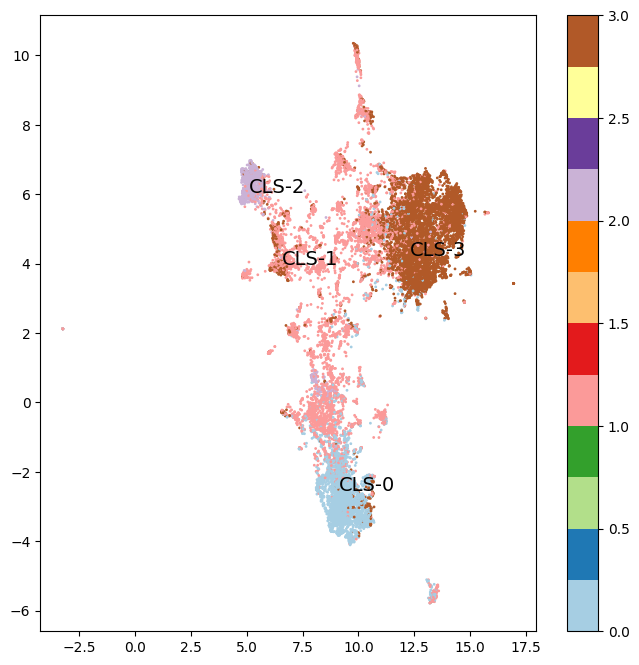

In [36]:
X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(8,8))
print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=14)
plt.colorbar()

In [37]:
# Add Cluster and embeddings as new columns in source dataframe
df_filtered['cluster'] = labels
df_filtered['embedding'] = corpus_embeddings.tolist()
df_filtered[['cluster','embedding','desc_without_stopwords']]

,cluster,embedding,desc_without_stopwords
0,3,"[0.020583901554346085, -0.013461971655488014, 0.06579974293708801, 0.05852262303233147, 0.012072693556547165, 0.04593225196003914, 0.009381513111293316, -0.10377705097198486, 0.053185444325208664, -0.029653960838913918, 0.025088723748922348, -0.039207469671964645, -0.09308837354183197, -0.061512332409620285, 0.10773486644029617, 0.045863550156354904, 0.06408931314945221, 0.016674136742949486, -0.012626801617443562, -0.01413729414343834, 0.05743628740310669, 0.09163356572389603, -0.0010610469616949558, 0.03416202589869499, 0.0165998637676239, -0.02282281033694744, 0.017532844096422195, 0.00857327040284872, -0.00882740132510662, -0.10525503009557724, 0.0883151963353157, 0.05832119658589363, 0.024241875857114792, -0.04875792935490608, -0.08822634071111679, 0.02532573789358139, 0.04802737757563591, -0.05205918848514557, 0.13991783559322357, 0.007622991222888231, 0.04113076627254486, 0.04478276148438454, 0.0014917391818016768, 0.01732398383319378, -0.05141249671578407, -0.04048624634742737, -0.03972058743238449, 0.015713857486844063, -0.005033052992075682, 0.034150704741477966, -0.04787963628768921, -0.02208559401333332, -0.02276451885700226, -0.010040945373475552, -0.06178269535303116, 0.03140907362103462, 0.03787756338715553, -0.04620666801929474, -0.00137683458160609, 0.04481137916445732, 0.004400609061121941, -0.054666917771101, -0.017922790721058846, -0.022103270515799522, -0.09463715553283691, -0.056105200201272964, -0.08903510868549347, 0.07891897857189178, 0.1170240193605423, -0.0730413869023323, 0.010068184696137905, -0.04353061690926552, -0.04514066502451897, 0.03259047865867615, -0.031007451936602592, 0.024921707808971405, 0.005000985227525234, -0.11412198096513748, -0.1184430792927742, -0.04585854336619377, -0.020559854805469513, 0.07386491447687149, -0.024566052481532097, 0.03828708082437515, 0.0021685424726456404, 0.020422426983714104, -0.07252686470746994, -0.036166753619909286, -0.03872256726026535, 0.04628026485443115, 0.07522198557853699, -0.028409916907548904, -0.10985390841960907, 0.0009099977323785424, 0.007503081113100052, 0.028896993026137352, 0.09677276760339737, -0.034187477082014084, -0.04917697235941887, 0.04686613380908966, ...]","Aromas include tropical fruit, broom, brimstone dried herb. The palate overly expressive, offering unripened apple, citrus dried sage alongside brisk acidity."
1,3,"[-0.01622132770717144, -0.10324912518262863, -0.05814259499311447, 0.08502774685621262, 0.051272790879011154, 0.0720963180065155, 0.05182954668998718, 0.010270532220602036, -0.0032846468966454268, -0.03294460475444794, 0.04602974280714989, 0.03365081548690796, -0.05801662057638168, -0.013606809079647064, 0.0973784402012825, 0.011246724054217339, 0.1061762198805809, 0.0038187317550182343, -0.03948470950126648, -0.03869812935590744, 0.032853614538908005, 0.03288732096552849, -0.03711127117276192, -0.02496952936053276, -0.026091763749718666, -0.009647802449762821, 0.020443279296159744, -0.04434429109096527, -0.009271865710616112, -0.09230971336364746, 0.04842866584658623, 0.09298130124807358, 0.10360656678676605, -0.07641085237264633, -0.07941856235265732, 0.07271085679531097, 0.044903334230184555, -0.06209886074066162, 0.07347847521305084, 0.028783120214939117, -0.009226861409842968, -0.02858324535191059, 0.06338561326265335, 0.013202274218201637, -0.016734754666686058, -0.01082605216652155, -0.02603032998740673, 0.014799931086599827, 0.035617273300886154, -0.06993058323860168, -0.022734908387064934, 0.015252695418894291, -0.05478658154606819, 0.005263182334601879, -0.015606261789798737, 0.09233434498310089, 0.0010251752100884914, -0.01631193421781063, 0.007684639189392328, 0.04975294694304466, 0.0011793397134169936, -0.04351511597633362, -0.004856456536799669, -0.019928470253944397, -0.09483350068330765, -0.03630620613694191, -0.02893158234655857, 0.002342803403735161, 0.05993343144655228, -0.1296427696943283, -0.0002473980712238699, -0.053594671189785004, 0.025506744161

#### Top Words per Clusters

In [38]:
# initialize
cv = CountVectorizer(stop_words='english') 
cv_matrix = cv.fit_transform(df_filtered['desc_without_stopwords']) 
# create document term matrix
df_dtm = pd.DataFrame(
    cv_matrix.toarray(), 
    index=df_filtered['desc_without_stopwords'].values, 
    columns=cv.get_feature_names_out()
)

df_dtm['cluster'] = labels

df_dtm.index.name = '_desc_'
df_word_count = df_dtm.groupby('cluster').sum().reset_index().melt(
    id_vars=['cluster'], var_name='_word_', value_name='_count_'
)

In [39]:
words_0 = df_word_count[df_word_count.cluster==0].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_0.head(5)

,cluster,_word_,_count_
0,0,palate,2645
1,0,white,2279
2,0,fruit,2244
3,0,acidity,1988
4,0,apple,1653


In [40]:
words_1 = df_word_count[df_word_count.cluster==1].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_1.head(5)

,cluster,_word_,_count_
0,1,fruit,3361
1,1,cherry,2439
2,1,spice,2167
3,1,offers,1674
4,1,bright,1531


In [41]:
words_2 = df_word_count[df_word_count.cluster==2].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_2.head(5)

,cluster,_word_,_count_
0,2,cabernet,1209
1,2,sauvignon,1139
2,2,black,783
3,2,blend,769
4,2,merlot,660


In [42]:
words_3 = df_word_count[df_word_count.cluster==3].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_3.head(5)

,cluster,_word_,_count_
0,3,palate,6190
1,3,tannins,5816
2,3,cherry,5112
3,3,black,4461
4,3,berry,2898


#### Can we reccomend (predict) wines based on a human's previous wine choices and the corresponding description embeddings?

In [ ]:
user_one_wines = []